In [1]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
from nltk.tokenize import word_tokenize
import re
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
nltk.download('punkt')

# 读取声明和证据数据
with open('data/train-claims.json', 'r') as file:
    data = json.load(file)
with open('data/evidence.json', 'r') as file:
    evidence_data = json.load(file)

# 准备输出数据列表
output_data = []
for claim_id, claim_info in data.items():
    claim_text = claim_info['claim_text']
    claim_label = claim_info['claim_label']
    if claim_label == "DISPUTED":
        continue  # 忽略 disputed 的声明
    label_mapping = {
        "SUPPORTS": "support",
        "REFUTES": "refute",
        "NOT_ENOUGH_INFO": "irrelevant"
    }
    if claim_label in label_mapping:
        for evidence_id in claim_info['evidences']:
            output_data.append({
                "claim_id": claim_id,
                "claim_text": claim_text,
                "evidence_id": evidence_id,
                "label": label_mapping[claim_label],
                "evidence_text": evidence_data.get(evidence_id, "")
            })

# 转换为 DataFrame 并分割数据集
df_output = pd.DataFrame(output_data)
train_df, valid_df = train_test_split(df_output, test_size=0.2, random_state=42)

# 函数来预处理和向量化文本
def preprocess_text(text):
    pattern = re.compile(r'\b[a-zA-Z0-9]+\b')
    tokens = word_tokenize(text.lower())
    filtered_tokens = [token for token in tokens if pattern.match(token)]
    return filtered_tokens

# 准备文档
train_documents = [TaggedDocument(words=preprocess_text(row['claim_text']) + preprocess_text(row['evidence_text']), tags=[str(i)]) for i, row in train_df.iterrows()]
valid_documents = [TaggedDocument(words=preprocess_text(row['claim_text']) + preprocess_text(row['evidence_text']), tags=[str(i)]) for i, row in valid_df.iterrows()]


[nltk_data] Downloading package punkt to /Users/edmba/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# 初始化 Doc2Vec 模型
model_d2v = Doc2Vec(vector_size=150, window=5, min_count=1, workers=4, epochs=50)

# 构建词汇表并训练模型
model_d2v.build_vocab(train_documents)
model_d2v.train(train_documents, total_examples=model_d2v.corpus_count, epochs=model_d2v.epochs)


In [3]:
# 设置计算设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_vectors(documents):
    vectors = np.array([model_d2v.infer_vector(doc.words) for doc in documents])
    return torch.tensor(vectors, dtype=torch.float).view(vectors.shape[0], 1, -1).to(device)

# 获取训练和验证数据向量
train_vectors = get_vectors(train_documents)
valid_vectors = get_vectors(valid_documents)

# 获取标签并转换为 tensor
train_labels = torch.tensor(train_df['label'].astype('category').cat.codes.to_numpy(), dtype=torch.long).to(device)
valid_labels = torch.tensor(valid_df['label'].astype('category').cat.codes.to_numpy(), dtype=torch.long).to(device)


In [4]:
# 打印label的各个类别的数量
print(train_df['label'].value_counts())


label
irrelevant    1538
support       1073
refute         373
Name: count, dtype: int64


In [5]:


# LSTM 模型定义
class LSTMModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, bidirectional=True, dropout=0.5, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        return self.fc(hidden)


# 实例化模型
model = LSTMModel(150, 256, 3).to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()


/Users/edmba/miniforge3/envs/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# 训练函数
def train(model, train_vectors, train_labels, optimizer, criterion, n_epochs):
    model.train()
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        outputs = model(train_vectors)
        loss = criterion(outputs, train_labels)
        loss.backward()
        optimizer.step()
        if epoch % 20 == 0:  # 每10个epoch输出一次信息
            print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

# 评估函数
def evaluate(model, valid_vectors, valid_labels):
    model.eval()
    with torch.no_grad():
        outputs = model(valid_vectors)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == valid_labels).sum().item()
        accuracy = correct / valid_labels.size(0)
    return accuracy


# 执行训练
n_epochs = 200
train(model, train_vectors, train_labels, optimizer, criterion, n_epochs=n_epochs)

# 执行评估
validation_accuracy = evaluate(model, valid_vectors, valid_labels)
print(f'Validation Accuracy: {validation_accuracy:.2f}')





Epoch 1, Loss: 1.0990257263183594
Epoch 21, Loss: 0.9304300546646118
Epoch 41, Loss: 0.8789675831794739
Epoch 61, Loss: 0.8387861847877502
Epoch 81, Loss: 0.7718189358711243
Epoch 101, Loss: 0.6792872548103333
Epoch 121, Loss: 0.5661942958831787
Epoch 141, Loss: 0.4582033157348633
Epoch 161, Loss: 0.3827079236507416
Epoch 181, Loss: 0.29483604431152344
Validation Accuracy: 0.63


In [ ]:
# 保存模型
torch.save(model.state_dict(), 'lstm_model.pth')


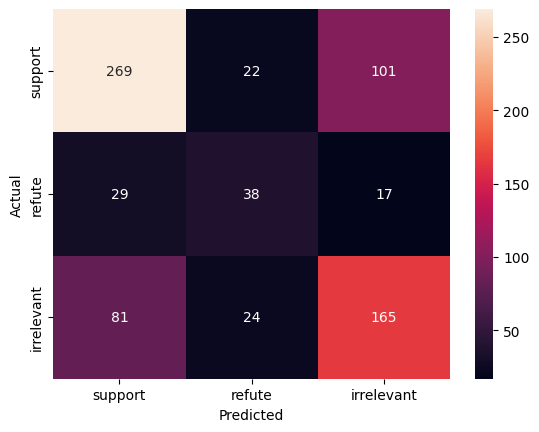

In [7]:
# 打印混淆矩阵
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    outputs = model(valid_vectors)
    _, predicted = torch.max(outputs, 1)
    cm = confusion_matrix(valid_labels.cpu(), predicted.cpu())
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=['support', 'refute', 'irrelevant'], yticklabels=['support', 'refute', 'irrelevant'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [8]:
# 打印分类报告
from sklearn.metrics import classification_report
print(classification_report(valid_labels.cpu(), predicted.cpu(), target_names=['support', 'refute', 'irrelevant']))


              precision    recall  f1-score   support

     support       0.71      0.69      0.70       392
      refute       0.45      0.45      0.45        84
  irrelevant       0.58      0.61      0.60       270

    accuracy                           0.63       746
   macro avg       0.58      0.58      0.58       746
weighted avg       0.63      0.63      0.63       746



In [24]:
import nltk
from nltk.corpus import wordnet
import random

# 确保已经下载所需的数据集
nltk.download('wordnet')
nltk.download('omw-1.4')

def synonym_replacement(text, num_replacements):
    """用同义词替换文本中的词来增强数据"""
    words = nltk.word_tokenize(text)
    new_text = words[:]
    random_word_list = list(set([word for word in words if word.isalpha()]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for word in random_word_list:
        synonyms = get_synonyms(word)
        if len(synonyms) > 0:
            synonym = random.choice(list(synonyms))
            new_text = [synonym if w == word else w for w in new_text]
            num_replaced += 1
        if num_replaced >= num_replacements:  # 控制替换数量
            break

    return ' '.join(new_text)

def get_synonyms(word):
    """获取单词的同义词集合"""
    synonyms = set()
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonym = l.name().replace('_', ' ').replace('-', ' ').lower()
            synonyms.add(synonym)
    if word in synonyms:
        synonyms.remove(word)
    return synonyms

# 接下来修改数据读取和预处理的部分，增加数据增强

import pandas as pd
import numpy as np

def augment_data(data, augment_rate=1):
    """根据给定的增强率增强数据"""
    new_rows = []
    for _, row in data.iterrows():
        new_rows.append(row)  # 添加原始行
        if row['claim_label'] in ['DISPUTED', 'REFUTES']:
            additions = 2  # 增加200%
        else:
            additions = 1  # 增加100%
        for _ in range(additions):
            new_row = row.copy()
            new_row['claim_text'] = synonym_replacement(row['claim_text'], num_replacements=2)
            new_rows.append(new_row)
    return pd.DataFrame(new_rows)

# 读取和增强数据
train_data = pd.read_csv('data/train_top/training_data_top_50_evidences.csv')
dev_data = pd.read_csv('data/dev_top/dev_data_top_50_evidences.csv')

train_data = augment_data(train_data)
dev_data = augment_data(dev_data)  # 可选择是否对开发集进行数据增强

# 后续步骤（训练和验证模型）保持不变


# 后续步骤（训练和验证模型）保持不变

# 继续使用之前定义的Doc2Vec模型和LSTM模型
# 假设这些模型都已经被定义和训练过了，并且已经加载到当前的环境中

def preprocess_and_vectorize(text):
    """文本预处理并返回向量化的结果"""
    tokens = preprocess_text(text)  # 使用前面定义的preprocess_text函数
    vector = model_d2v.infer_vector(tokens)  # 使用Doc2Vec模型生成向量
    return vector

def predict_evidence(model, evidence_vector):
    """预测单个证据的标签"""
    vector_tensor = torch.tensor(evidence_vector, dtype=torch.float).view(1, 1, -1).to(device)
    model.eval()
    with torch.no_grad():
        output = model(vector_tensor)
        _, predicted = torch.max(output, 1)
    return predicted.item()  # 返回预测的标签索引

def feature_engineering(predictions):
    """基于预测结果生成特征"""
    counts = np.bincount(predictions, minlength=3)
    return counts / np.sum(counts)  # 返回每个标签的相对频率作为特征

# 处理claims并生成训练特征和标签
def process_claims(data, model):
    features = []
    labels = []
    grouped = data.groupby('claim_id')
    for claim_id, group in grouped:
        predictions = []
        for _, row in group.iterrows():
            vector = preprocess_and_vectorize(row['evidence_text'])
            pred = predict_evidence(model, vector)
            predictions.append(pred)
        claim_features = feature_engineering(predictions)
        features.append(claim_features)
        labels.append(row['claim_label'])  # 假设每个group的最后一行包含claim的标签
    return np.array(features), np.array(labels)

# 生成训练和验证特征
train_features, train_labels = process_claims(train_data, model)
valid_features, valid_labels = process_claims(dev_data, model)




[nltk_data] Downloading package wordnet to /Users/edmba/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/edmba/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Validation Accuracy: 0.44


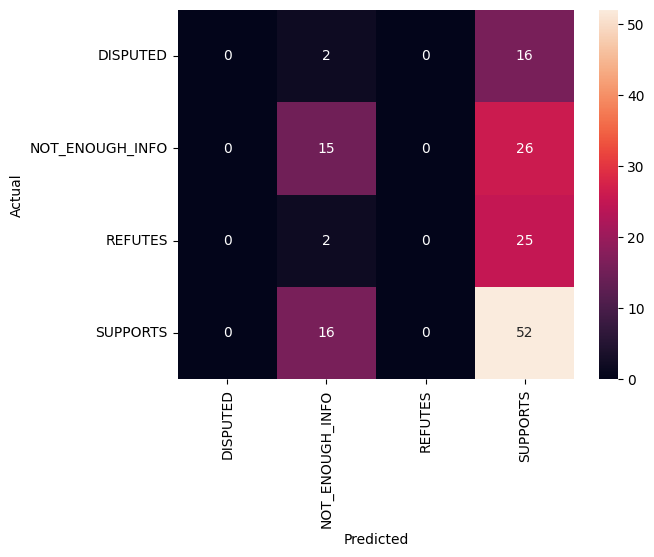

In [25]:
# 训练逻辑回归模型
lr_model = LogisticRegression(random_state=42)
lr_model.fit(train_features, train_labels)

# 验证模型
valid_predictions = lr_model.predict(valid_features)
accuracy = accuracy_score(valid_labels, valid_predictions)
print(f'Validation Accuracy: {accuracy:.2f}')

# 绘制混淆矩阵
cm = confusion_matrix(valid_labels, valid_predictions)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=lr_model.classes_, yticklabels=lr_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [26]:
print(classification_report(valid_labels, valid_predictions, target_names=lr_model.classes_))
print(lr_model.coef_)
print(len(train_features))

                 precision    recall  f1-score   support

       DISPUTED       0.00      0.00      0.00        18
NOT_ENOUGH_INFO       0.43      0.37      0.39        41
        REFUTES       0.00      0.00      0.00        27
       SUPPORTS       0.44      0.76      0.56        68

       accuracy                           0.44       154
      macro avg       0.22      0.28      0.24       154
   weighted avg       0.31      0.44      0.35       154

[[-0.47317286  0.1465196   0.32579774]
 [ 2.24831226 -1.02101663 -1.22659887]
 [-1.10530456  2.0732584  -0.96804422]
 [-0.66983483 -1.19876136  1.86884535]]
1228


/Users/edmba/miniforge3/envs/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/edmba/miniforge3/envs/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/edmba/miniforge3/envs/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [18]:
import nltk
from nltk.corpus import wordnet
import random

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

def synonym_replacement(sentence, n):
    words = sentence.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word.isalpha()]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:  # 只替换n个词
            break

    sentence = ' '.join(new_words)
    return sentence

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace('_', ' ').replace('-', ' ').lower()
            synonym = "".join([char for char in synonym if char.isalpha() or char == ' '])
            synonyms.add(synonym)
    if word in synonyms:
        synonyms.remove(word)
    return synonyms

# 示例
input_sentence = "Studies have shown that people who smoke may have an increased risk of COVID-19 severity."
enhanced_sentence = synonym_replacement(input_sentence, 3)
print("Original:", input_sentence)
print("Enhanced:", enhanced_sentence)


[nltk_data] Downloading package wordnet to /Users/edmba/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/edmba/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Original: Studies have shown that people who smoke may have an increased risk of COVID-19 severity.
Enhanced: survey have picture that people who smoke may have an increase risk of COVID-19 severity.


In [ ]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 定义基模型，注意有些模型需要数据预处理，比如归一化
base_models = [
    ('lr', LogisticRegression(random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svm', make_pipeline(StandardScaler(), LinearSVC(random_state=42))),
    ('mlp', MLPClassifier(hidden_layer_sizes=(50,), random_state=42)),
    ('gnb', MultinomialNB()),
    ('sgd', make_pipeline(StandardScaler(), SGDClassifier(random_state=42))),
    ('lgbm', LGBMClassifier(random_state=42)),
    ('ridge', RidgeClassifier(random_state=42)),
    ('perceptron', make_pipeline(StandardScaler(), Perceptron(random_state=42))),
    ('pac', make_pipeline(StandardScaler(), PassiveAggressiveClassifier(random_state=42))),
    ('gbc', GradientBoostingClassifier(random_state=42)),
    ('etc', ExtraTreesClassifier(n_estimators=100, random_state=42)),
    ('catboost', CatBoostClassifier(verbose=0, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)),
    ('knn', make_pipeline(StandardScaler(), KNeighborsClassifier()))
]

# 定义元学习器
meta_learner = LGBMClassifier(random_state=42)

# 创建堆叠分类器
stack = StackingClassifier(estimators=base_models, final_estimator=meta_learner, cv=5, stack_method='auto')

# 训练模型
stack.fit(train_features, train_labels)

# 验证模型
valid_predictions = stack.predict(valid_features)
accuracy = accuracy_score(valid_labels, valid_predictions)
print(f'Validation Accuracy: {accuracy:.2f}')

# 混淆矩阵和分类报告
print("\nClassification Report:\n", classification_report(valid_labels, valid_predictions))
cm = confusion_matrix(valid_labels, valid_predictions)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=stack.classes_, yticklabels=stack.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#保存模型
import joblib
joblib.dump(stack, 'stacking_model.joblib')


In [28]:
test_data = pd.read_csv('data/test_top/test_data_top_50_evidences.csv')
# 将test_data的label列改名为claim_label
test_data.rename(columns={'label': 'claim_label'}, inplace=True)

test_features, test_labels = process_claims(test_data, model)



In [29]:
print(test_features)

[[0.6  0.06 0.34]
 [0.36 0.14 0.5 ]
 [0.48 0.18 0.34]
 [0.36 0.14 0.5 ]
 [0.78 0.06 0.16]
 [0.82 0.04 0.14]
 [0.5  0.12 0.38]
 [0.48 0.14 0.38]
 [0.3  0.22 0.48]
 [0.3  0.14 0.56]
 [0.4  0.36 0.24]
 [0.52 0.18 0.3 ]
 [0.64 0.06 0.3 ]
 [0.56 0.08 0.36]
 [0.6  0.28 0.12]
 [0.68 0.2  0.12]
 [0.64 0.08 0.28]
 [0.48 0.12 0.4 ]
 [0.32 0.2  0.48]
 [0.42 0.22 0.36]
 [0.66 0.08 0.26]
 [0.48 0.14 0.38]
 [0.34 0.18 0.48]
 [0.44 0.1  0.46]
 [0.66 0.02 0.32]
 [0.56 0.16 0.28]
 [0.54 0.26 0.2 ]
 [0.38 0.1  0.52]
 [0.7  0.08 0.22]
 [0.52 0.14 0.34]
 [0.54 0.14 0.32]
 [0.54 0.12 0.34]
 [0.48 0.16 0.36]
 [0.56 0.1  0.34]
 [0.58 0.08 0.34]
 [0.32 0.12 0.56]
 [0.46 0.16 0.38]
 [0.6  0.12 0.28]
 [0.42 0.14 0.44]
 [0.44 0.16 0.4 ]
 [0.52 0.22 0.26]
 [0.4  0.08 0.52]
 [0.42 0.12 0.46]
 [0.5  0.24 0.26]
 [0.44 0.08 0.48]
 [0.54 0.06 0.4 ]
 [0.52 0.3  0.18]
 [0.3  0.14 0.56]
 [0.56 0.18 0.26]
 [0.48 0.18 0.34]
 [0.74 0.   0.26]
 [0.44 0.2  0.36]
 [0.62 0.18 0.2 ]
 [0.46 0.18 0.36]
 [0.64 0.14 0.22]
 [0.56 0.1

In [ ]:
test_predictions = stack.predict(test_features)

print("\nClassification Report:\n", classification_report(test_labels, test_predictions))

In [30]:
import json

# Load the original JSON file
with open('test-claims-baseline.json', 'r') as file:
    data = json.load(file)

# Correct the nested structure in 'claim_text'
for claim_id, claim_info in data.items():
    if 'claim_text' in claim_info and isinstance(claim_info['claim_text'], dict):
        claim_info['claim_text'] = claim_info['claim_text']['claim_text']

# Save the corrected JSON file
with open('corrected_test-claims-baseline.json', 'w') as file:
    json.dump(data, file, indent=4)

print("File corrected and saved!")


File corrected and saved!
